In [1]:
from sudoku import Sudoku, SudokuGenerator
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import random
import os
import time
from matplotlib.patches import Patch

In [2]:
# Device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")



Using CUDA: NVIDIA RTX A4000
Device: cuda


In [3]:

# HYPERPARAMETERS
N_EPOCHS = 100
LEARNING_RATE = 0.001
ATTENTION_DIM = 9
N_HEADS = 9
EMBEDDING_DIM = 15
TRAIN_PUZZLES = 20000
VAL_PUZZLES = 512
BATCH_SIZE = 512
VALIDATE_PERIOD = 10  # Run validation every N epochs
CHECKPOINT_PERIOD = 10  # Save checkpoint every N epochs
CHECKPOINT_DIR = "./sudoku_checkpoints"  # Directory to save checkpoints
LOAD_CHECKPOINT = None  # Path to checkpoint to load, or None to start fresh
SAVE_CHECKPOINT = True
SAMPLES_PER_PUZZLE = 3
NEGATIVE_SAMPLES_SIZE = 1
USE_NEGATIVE_SAMPLES = False


assert ATTENTION_DIM % N_HEADS == 0

# Create checkpoint directory if it doesn't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def get_checkpoint_filename(epoch=None):
    """Generate checkpoint filename with hyperparameters"""
    filename = f"sudoku_emb{EMBEDDING_DIM}_att{ATTENTION_DIM}_h{N_HEADS}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"
    if epoch is not None:
        filename += f"_epoch{epoch}"
    else:
        filename += "_final"
    filename += ".pt"
    return os.path.join(CHECKPOINT_DIR, filename)


In [4]:

class PositionalEncoding(nn.Module):
    # for a 9 by 9 sudoku grid
    # subdivide a unit circle into 81 sections
    # and return x, y coordinates of that output
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        # Create a grid of positions (0-8 for both x and y)
        x_coords = torch.arange(0, 9).unsqueeze(0).repeat(9, 1)
        y_coords = torch.arange(0, 9).unsqueeze(1).repeat(1, 9)
        
        # Convert grid positions to linear indices (0-80)
        linear_indices = y_coords * 9 + x_coords  # shape: (9, 9)
        
        # Convert linear indices to angles on unit circle
        angles = 2 * math.pi * linear_indices / 81  # shape: (9, 9)
        
        # Compute x, y coordinates on unit circle
        x_circle = torch.cos(angles)
        y_circle = torch.sin(angles)
        
        # Stack and add batch dimension
        pos_encoding = torch.stack([x_circle, y_circle], dim=-1).unsqueeze(0)  # shape: (1, 9, 9, 2)
        self.register_buffer('pos_encoding', pos_encoding)
    
    def get_embedding_for_position(self, pos):
        # input (batch, 2) where pos[:, 0] is x and pos[:, 1] is y
        # Convert to linear indices
        linear_indices = pos[:, 1] * 9 + pos[:, 0]  # shape: (batch,)
        
        # Convert to angles on unit circle
        angles = 2 * math.pi * linear_indices / 81  # shape: (batch,)
        
        # Compute x, y coordinates on unit circle
        x_circle = torch.cos(angles).unsqueeze(1)  # shape: (batch, 1)
        y_circle = torch.sin(angles).unsqueeze(1)  # shape: (batch, 1)
        
        return torch.cat([x_circle, y_circle], dim=1)  # shape: (batch, 2)
    
    def forward(self, x):
        # x is a (batch, 9, 9, embedding_dim) grid
        # output (batch, 9, 9, embedding_dim + 2) grid by adding pos_encoding to x
        batch_size = x.shape[0]
        pos_expanded = self.pos_encoding.repeat(batch_size, 1, 1, 1)
        # Concatenate along the last dimension: (batch, 9, 9, embedding_dim + 2)
        return torch.cat([x, pos_expanded], dim=-1)
    
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, input_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # seperate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0,2,1,3) # [batch, head, seqlen, dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0,2,1,3) # [batch, seqlen, head, dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values) # [batch, seq_length, 81]

        if return_attention:
            return o, attention
        else:
            return o

class Sudoku2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim, attention_dim=ATTENTION_DIM, num_heads=N_HEADS, device='cpu'):
        super(Sudoku2Vec, self).__init__()
        self.device = device
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        self.pe = PositionalEncoding()
        self.embed = nn.Embedding(vocab_size, embedding_dim) # this will provide the key queries and values
        self.total_dim = self.embedding_dim + 2

        self.mha = MultiheadAttention(
            input_dim=self.total_dim,
            embed_dim=attention_dim,
            num_heads=num_heads
        )
        
        # Move model to device
        self.to(device)
    
    def get_embeddings(self):
        """
        Returns the learned token embeddings.
        
        Returns:
            torch.Tensor: Embedding weight matrix of shape [vocab_size, embedding_dim]
        """
        return self.embed.weight.detach()
    
    def get_embedding_for_token(self, token):
        """
        Get the embedding vector for a specific token.
        
        Args:
            token: Integer token ID or tensor of token IDs
            
        Returns:
            torch.Tensor: Embedding vector(s) for the given token(s)
        """
        if isinstance(token, int):
            token = torch.tensor([token], device=self.device)
        elif not isinstance(token, torch.Tensor):
            token = torch.tensor(token, device=self.device)
        return self.embed(token).detach()
    
    def save_model(self, filepath):
        """
        Save the model in a portable format that can be easily loaded.
        This saves the model architecture and weights in a single file.
        
        Args:
            filepath: Path where to save the model (should end with .pt or .pth)
        """
        save_dict = {
            'model_state_dict': self.state_dict(),
            'model_config': {
                'vocab_size': self.embed.num_embeddings,
                'embedding_dim': self.embedding_dim,
                'attention_dim': self.mha.embed_dim,
                'num_heads': self.num_heads,
            },
            'model_class': 'Sudoku2Vec',
        }
        torch.save(save_dict, filepath)
        print(f"Model saved to {filepath}")
    
    @classmethod
    def load_model(cls, filepath, device='cpu'):
        """
        Load a saved Sudoku2Vec model from file.
        
        Args:
            filepath: Path to the saved model file
            device: Device to load the model on ('cpu', 'cuda', 'mps')
            
        Returns:
            Sudoku2Vec: Loaded model instance
        """
        checkpoint = torch.load(filepath, map_location=device)
        
        # Extract configuration
        config = checkpoint['model_config']
        
        # Create model instance
        model = cls(
            vocab_size=config['vocab_size'],
            embedding_dim=config['embedding_dim'],
            attention_dim=config['attention_dim'],
            num_heads=config['num_heads'],
            device=device
        )
        
        # Load weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()  # Set to evaluation mode by default
        
        print(f"Model loaded from {filepath}")
        print(f"Configuration: vocab_size={config['vocab_size']}, "
              f"embedding_dim={config['embedding_dim']}, "
              f"attention_dim={config['attention_dim']}, "
              f"num_heads={config['num_heads']}")
        
        return model
    
    def forward(self, target, position, sudoku_grid, mask=True):
        # target - the token in the target blank space we try to predict shape [batch] i.e [0, 3, 3, 5, 1, ...]
        # position - the (x, y) position of the target shape [batch, 2] - [[1, 1], [0, 3], [7,7], ...]
        # sudoku_grid - the sudoku grid for the problem with target we want to predict shape [batch, 9, 9]
        batch_size = target.shape[0]
        
        target_token_embeddings = self.embed(target) # shape [batch, embedding_dim]
        target_position_vectors = self.pe.get_embedding_for_position(position) # [batch, 2]
        target_token_with_position = torch.cat([target_token_embeddings, target_position_vectors], dim=-1)  # shape [batch, total_dim]

        # mask the target in the grid
        sudoku_grid_masked = sudoku_grid
        if mask:
            batch_indices = torch.arange(sudoku_grid.shape[0], device=self.device)
            sudoku_grid_masked = sudoku_grid.clone()
            sudoku_grid_masked[batch_indices, position[:, 1], position[:, 0]] = 0 # 0 is a mask token aka blank
        
        masked_sudoku_grid_embeddings = self.embed(sudoku_grid_masked)
        masked_sudoku_grid_with_position = self.pe(masked_sudoku_grid_embeddings) # shape [batch, 9, 9, total_dim]
        # Reshape grid to sequence: [batch, 81, total_dim]
        masked_grid_seq = masked_sudoku_grid_with_position.view(batch_size, 81, self.total_dim)

        grid_seq_embeddings = self.embed(sudoku_grid)
        grid_seq_embeddings = grid_seq_embeddings.view(batch_size, 81, self.embedding_dim) 
        
        # Query from target token: [batch, 1, total_dim]
        # query = target_token_with_position.unsqueeze(1)

        output, attention = self.mha(masked_grid_seq, return_attention=True)
        # output is shape [batch, 81, total_dim]
        
        return output, attention, target_token_with_position, grid_seq_embeddings
    
    def loss(self, target, position, sudoku_grid, negative_samples=NEGATIVE_SAMPLES_SIZE, use_negative_samples=USE_NEGATIVE_SAMPLES, debug=False):
        """
        Compute contrastive loss for the model.
        
        The loss combines two components:
        1. Margin-based Contrastive Loss: Encourages the model to distinguish between correct (positive) 
           and incorrect (negative) token predictions by maximizing positive scores and minimizing negative scores.
           (Optional - controlled by use_negative_samples parameter)
        2. Cosine Similarity Loss: Directly maximizes the cosine similarity between predicted and 
           ground truth embeddings.
        
        Mathematical formulation:
        
        For a batch of examples, let:
        - z_i = output embedding at target position i (from attention output)
        - p_i = ground truth embedding at target position i (from target token embedding)
        - n_{i,j} = j-th negative sample embedding for example i
        
        Cosine Similarity (computed ONLY at target position):
            cos_sim(z_i, p_i) = (z_i · p_i) / (||z_i|| ||p_i||)
        
        Margin-based Contrastive Loss (per example i) - OPTIONAL:
            L_contrastive = max(0, margin - cos_sim(z_i, p_i)) + Σ_j max(0, cos_sim(z_i, n_{i,j}))
        
        This loss:
        - Penalizes positive scores below the margin (encourages positive scores to be high)
        - Penalizes positive negative scores (encourages negative scores to be low/negative)
        
        Cosine Loss:
            L_cosine = 1 - mean(cos_sim(z_i, p_i))
        
        Total Loss:
            If use_negative_samples is True:
                L_total = L_contrastive + L_cosine
            If use_negative_samples is False:
                L_total = L_cosine
        
        Relationship between the two losses:
        - Both losses encourage high cosine similarity between predicted and ground truth embeddings
        - L_contrastive uses a margin-based objective: it ensures positive similarity is high (above margin)
          and negative similarities are low (below 0)
        - L_cosine provides a direct gradient signal to maximize positive similarity without 
          considering negatives
        - Together, they provide both relative ranking (contrastive) and absolute alignment (cosine)
        
        Args:
            target: Ground truth tokens [batch]
            position: Target positions [batch, 2]
            sudoku_grid: Sudoku grids [batch, 9, 9]
            negative_samples: Number of negative samples per positive example (only used if use_negative_samples=True)
            use_negative_samples: Whether to use negative samples for contrastive loss
            debug: If True, visualize embeddings, cosine similarity, sudoku grids, and attention maps
        
        Returns:
            total_loss: Combined loss value
            contrastive_loss: Margin-based contrastive loss component (0 if use_negative_samples=False)
            cosine_loss: Cosine similarity loss component
            accuracy: Prediction accuracy based on closest cosine similarity to vocab embeddings
        """
        batch_size = target.shape[0]
        
        # Forward pass to get output and target embeddings
        output, attention, target_token_with_position, grid_embeddings_flat = self.forward(target, position, sudoku_grid, mask=True)
        # output is shape [batch, seq_length, total_dim]
        
        # Extract only the embedding portion (without position vectors) from output
        # output is [batch, 81, total_dim] where total_dim = embedding_dim + 2
        # We want only the first embedding_dim dimensions
        output_embeddings = output[:, :, :self.embedding_dim]  # shape [batch, 81, embedding_dim]
        
        # Normalize embeddings for cosine similarity computation
        output_norm = F.normalize(output_embeddings, p=2, dim=-1)  # [batch, 81, embedding_dim]
        grid_norm = F.normalize(grid_embeddings_flat, p=2, dim=-1)  # [batch, 81, embedding_dim]
        
        # === Extract embeddings at target positions ===
        batch_indices = torch.arange(batch_size, device=self.device)
        # Convert 2D positions to linear indices
        linear_indices = position[:, 1] * 9 + position[:, 0]  # [batch]
        
        # Get output embeddings at target positions (z_i)
        output_at_target = output_embeddings[batch_indices, linear_indices, :]  # [batch, embedding_dim]
        output_at_target_norm = F.normalize(output_at_target, p=2, dim=-1)  # [batch, embedding_dim]
        
        # Get ground truth embeddings at target positions (p_i)
        ground_truth_at_target = grid_embeddings_flat[batch_indices, linear_indices, :]  # [batch, embedding_dim]
        ground_truth_at_target_norm = F.normalize(ground_truth_at_target, p=2, dim=-1)  # [batch, embedding_dim]
        
        # Compute positive cosine similarity ONLY at target position
        # This is cos_sim(z_i, p_i) where i is the target position
        positive_scores = (output_at_target_norm * ground_truth_at_target_norm).sum(dim=-1)  # [batch]
        
        # Compute positive scores for all positions (for debugging/visualization)
        positive_scores_per_position = (output_norm * grid_norm).sum(dim=-1)  # [batch, 81]
        
        # === Margin-based Contrastive Loss (Optional) ===
        margin = 1.0  # Target margin for positive scores
        
        # Loss for positive scores: penalize if below margin
        # max(0, margin - positive_score) encourages positive_score >= margin
        positive_loss = torch.clamp(margin - positive_scores, min=0).mean()
        vocab_size = self.embed.num_embeddings
        
        if use_negative_samples:
            # === Negative sampling for contrastive loss ===
            # Generate negative samples (n_{i,j})
            # Sample random tokens that are not the target
            negative_targets = []
            for i in range(batch_size):
                # Sample negative_samples tokens different from target[i]
                neg_samples = []
                while len(neg_samples) < negative_samples:
                    neg_token = torch.randint(0, vocab_size, (1,), device=self.device)
                    if neg_token.item() != target[i].item():
                        neg_samples.append(neg_token)
                negative_targets.append(torch.cat(neg_samples))
            negative_targets = torch.stack(negative_targets)  # [batch, negative_samples]
            
            # Get embeddings for negative samples (only the embedding part, no position)
            negative_embeddings = self.embed(negative_targets)  # [batch, negative_samples, embedding_dim]
            
            # Compute cosine similarity between output at target position and negative samples
            # This is cos_sim(z_i, n_{i,j})
            output_at_target_norm_expanded = output_at_target_norm.unsqueeze(1)  # [batch, 1, embedding_dim]
            negative_norm = F.normalize(negative_embeddings, p=2, dim=-1)  # [batch, negative_samples, embedding_dim]
            negative_scores = (output_at_target_norm_expanded * negative_norm).sum(dim=-1)  # [batch, negative_samples]
            
            # Loss for negative scores: penalize if above 0
            # max(0, negative_score) encourages negative_score <= 0
            negative_loss = torch.clamp(negative_scores, min=-1).mean()
            
            # Combine positive and negative losses
            contrastive_loss = negative_loss
        else:
            # No negative sampling - set negative loss to 0
            negative_loss = torch.tensor(0.0, device=self.device, dtype=output.dtype)
            contrastive_loss = negative_loss
        
        # === Cosine Similarity Loss ===
        # Simple loss: 1 - cosine similarity (encourages similarity to approach 1)
        cosine_loss = positive_loss
        
        # === Combine both losses ===
        # The contrastive loss ensures positive scores are high and negative scores are low (if enabled)
        # The cosine loss ensures absolute alignment (positive → 1)
        total_loss = contrastive_loss + cosine_loss
        
        # === Compute Accuracy ===
        # For each example in the batch, find which token embedding has highest cosine similarity
        # with the output embedding at the target position
        
        # Get all token embeddings from the embedding layer [vocab_size, embedding_dim]
        all_token_embeddings = self.embed.weight  # [vocab_size, embedding_dim]
        all_token_embeddings_norm = F.normalize(all_token_embeddings, p=2, dim=-1)  # [vocab_size, embedding_dim]
        
        # Compute cosine similarity between output at target and all vocab tokens
        # output_at_target_norm: [batch, embedding_dim]
        # all_token_embeddings_norm: [vocab_size, embedding_dim]
        # We want: [batch, vocab_size]
        similarity_to_all_tokens = torch.matmul(output_at_target_norm, all_token_embeddings_norm.T)  # [batch, vocab_size]
        
        # Get the predicted token (argmax of cosine similarities)
        predicted_tokens = torch.argmax(similarity_to_all_tokens, dim=-1)  # [batch]
        
        # Compute accuracy
        correct_predictions = (predicted_tokens == target).float()
        accuracy = correct_predictions.mean()
        
        # === Debug Visualization ===
        if debug:
            
            # We'll visualize the first sample in the batch
            sample_idx = 0
            
            # Number colors for sudoku visualization
            number_colors = {
                1: '#FFB3BA',  # Light red
                2: '#FFDFBA',  # Light orange
                3: '#FFFFBA',  # Light yellow
                4: '#BAFFC9',  # Light green
                5: '#BAE1FF',  # Light blue
                6: '#D4BAFF',  # Light purple
                7: '#FFB3E6',  # Light pink
                8: '#C9C9C9',  # Light gray
                9: '#FFD4BA',  # Light peach
            }
            
            print("\n" + "="*80)
            print("DEBUG MODE: Visualizing Model Internals")
            print("="*80)
            
            # 1. SUDOKU GRID AND TARGET VISUALIZATION
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Original grid
            ax = axes[0]
            puzzle = sudoku_grid[sample_idx].cpu().numpy()
            pos = position[sample_idx].cpu().numpy()
            tgt = target[sample_idx].item()
            
            for i in range(9):
                for j in range(9):
                    if puzzle[i, j] != 0:
                        color = number_colors[puzzle[i, j]]
                        rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                                 edgecolor='none', facecolor=color, alpha=0.6)
                        ax.add_patch(rect)
            
            for i in range(10):
                linewidth = 2 if i % 3 == 0 else 0.5
                ax.axhline(i, color='black', linewidth=linewidth)
                ax.axvline(i, color='black', linewidth=linewidth)
            
            for i in range(9):
                for j in range(9):
                    if puzzle[i, j] != 0:
                        ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                               ha='center', va='center', fontsize=12, fontweight='bold')
            
            # Mark target position
            ax.plot(pos[0] + 0.5, pos[1] + 0.5, 'r*', markersize=20, markeredgecolor='darkred', markeredgewidth=2)
            
            ax.set_xlim(0, 9)
            ax.set_ylim(0, 9)
            ax.set_aspect('equal')
            ax.invert_yaxis()
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Original Sudoku Grid\nTarget: {tgt} at Position ({pos[0]}, {pos[1]})', fontweight='bold')
            
            # Masked grid
            ax = axes[1]
            masked_puzzle = sudoku_grid.clone()
            masked_puzzle[sample_idx, pos[1], pos[0]] = 0
            masked_puzzle = masked_puzzle[sample_idx].cpu().numpy()
            
            for i in range(9):
                for j in range(9):
                    if masked_puzzle[i, j] != 0:
                        color = number_colors[masked_puzzle[i, j]]
                        rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                                 edgecolor='none', facecolor=color, alpha=0.6)
                        ax.add_patch(rect)
            
            for i in range(10):
                linewidth = 2 if i % 3 == 0 else 0.5
                ax.axhline(i, color='black', linewidth=linewidth)
                ax.axvline(i, color='black', linewidth=linewidth)
            
            for i in range(9):
                for j in range(9):
                    if masked_puzzle[i, j] != 0:
                        ax.text(j + 0.5, i + 0.5, str(masked_puzzle[i, j]), 
                               ha='center', va='center', fontsize=12, fontweight='bold')
            
            # Mark target position (empty)
            ax.plot(pos[0] + 0.5, pos[1] + 0.5, 'r*', markersize=20, markeredgecolor='darkred', markeredgewidth=2)
            
            ax.set_xlim(0, 9)
            ax.set_ylim(0, 9)
            ax.set_aspect('equal')
            ax.invert_yaxis()
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Masked Sudoku Grid (Input to Model)\nPosition ({pos[0]}, {pos[1]}) is Masked', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # 2. EMBEDDINGS VISUALIZATION
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            
            # Output embeddings at all positions (reshaped to 9x9 grid)
            ax = axes[0, 0]
            output_emb_2d = output_embeddings[sample_idx].cpu().detach().float().numpy()  # [81, embedding_dim]
            output_emb_grid = output_emb_2d.reshape(9, 9, -1)  # [9, 9, embedding_dim]
            # Visualize L2 norm of embeddings
            output_norms = np.linalg.norm(output_emb_grid, axis=-1)  # [9, 9]
            im = ax.imshow(output_norms, cmap='viridis', aspect='auto')
            ax.set_title('Output Embedding Norms (9x9 Grid) - attention output', fontweight='bold')
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            plt.colorbar(im, ax=ax)
            
            # Mark target position
            ax.plot(pos[0], pos[1], 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)
            
            # Grid embeddings (ground truth)
            ax = axes[0, 1]
            grid_emb_2d = grid_embeddings_flat[sample_idx].cpu().detach().float().numpy()  # [81, embedding_dim]
            grid_emb_grid = grid_emb_2d.reshape(9, 9, -1)  # [9, 9, embedding_dim]
            grid_norms = np.linalg.norm(grid_emb_grid, axis=-1)  # [9, 9]
            im = ax.imshow(grid_norms, cmap='viridis', aspect='auto')
            ax.set_title('Grid Embedding Norms (Ground Truth) - embedding of the grid not masked', fontweight='bold')
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            plt.colorbar(im, ax=ax)
            
            # Mark target position
            ax.plot(pos[0], pos[1], 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)
            
            # Output embedding at target position
            ax = axes[1, 0]
            output_at_target_vec = output_at_target[sample_idx].cpu().detach().float().numpy()
            ax.bar(range(len(output_at_target_vec)), output_at_target_vec)
            ax.set_title(f'Output Embedding at Target Position\n(Dimension: {len(output_at_target_vec)})', fontweight='bold')
            ax.set_xlabel('Embedding Dimension')
            ax.set_ylabel('Value')
            ax.grid(alpha=0.3)
            
            # Ground truth embedding at target position
            ax = axes[1, 1]
            linear_idx = position[sample_idx, 1] * 9 + position[sample_idx, 0]
            gt_at_target_vec = grid_embeddings_flat[sample_idx, linear_idx].cpu().detach().float().numpy()
            ax.bar(range(len(gt_at_target_vec)), gt_at_target_vec)
            ax.set_title(f'Ground Truth Embedding at Target Position\n(Token: {tgt})', fontweight='bold')
            ax.set_xlabel('Embedding Dimension')
            ax.set_ylabel('Value')
            ax.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # 3. ALL TOKEN EMBEDDINGS VISUALIZATION (NORMALIZED)
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Visualize all token embeddings as a heatmap
            ax = axes[0]
            all_token_emb_np = all_token_embeddings.cpu().detach().float().numpy()  # [vocab_size, embedding_dim]
            im = ax.imshow(all_token_emb_np, cmap='coolwarm', aspect='auto', interpolation='nearest')
            ax.set_title('All Token Embeddings (Raw)', fontweight='bold')
            ax.set_xlabel('Embedding Dimension')
            ax.set_ylabel('Token ID')
            ax.set_yticks(range(vocab_size))
            plt.colorbar(im, ax=ax)
            
            # Visualize normalized token embeddings
            ax = axes[1]
            all_token_emb_norm_np = all_token_embeddings_norm.cpu().detach().float().numpy()  # [vocab_size, embedding_dim]
            im = ax.imshow(all_token_emb_norm_np, cmap='coolwarm', aspect='auto', interpolation='nearest')
            ax.set_title('All Token Embeddings (Normalized)', fontweight='bold')
            ax.set_xlabel('Embedding Dimension')
            ax.set_ylabel('Token ID')
            ax.set_yticks(range(vocab_size))
            plt.colorbar(im, ax=ax)
            
            plt.tight_layout()
            plt.show()
            
            # 4. COSINE SIMILARITY VISUALIZATION
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Cosine similarity across all positions (reshaped to 9x9 grid)
            ax = axes[0]
            positive_scores_grid = positive_scores_per_position[sample_idx].view(9, 9).cpu().detach().float().numpy()
            im = ax.imshow(positive_scores_grid, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
            ax.set_title('Cosine Similarity (Output vs Ground Truth) - All Positions and normed', fontweight='bold')
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            
            # Add text annotations
            for i in range(9):
                for j in range(9):
                    text = ax.text(j, i, f'{positive_scores_grid[i, j]:.2f}', 
                                  ha='center', va='center', fontsize=8,
                                  color='black' if abs(positive_scores_grid[i, j]) < 0.5 else 'white')
            
            plt.colorbar(im, ax=ax)
            
            # Mark target position
            ax.plot(pos[0], pos[1], 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)
            
            # Cosine similarity between output at target and all vocab tokens
            ax = axes[1]
            vocab_similarities = similarity_to_all_tokens[sample_idx].cpu().detach().float().numpy()
            colors = ['green' if i == tgt else 'blue' if i == predicted_tokens[sample_idx].item() else 'gray' 
                     for i in range(len(vocab_similarities))]
            ax.bar(range(len(vocab_similarities)), vocab_similarities, color=colors, alpha=0.7)
            ax.set_title(f'Cosine Similarity: Output @ Target vs All Vocab Tokens\nGreen=GT({tgt}), Blue=Pred({predicted_tokens[sample_idx].item()})', 
                        fontweight='bold')
            ax.set_xlabel('Token ID')
            ax.set_ylabel('Cosine Similarity')
            ax.set_xticks(range(len(vocab_similarities)))
            ax.grid(alpha=0.3, axis='y')
            
            # Add legend
            legend_elements = [
                Patch(facecolor='green', alpha=0.7, label=f'Ground Truth (Token {tgt})'),
                Patch(facecolor='blue', alpha=0.7, label=f'Predicted (Token {predicted_tokens[sample_idx].item()})'),
                Patch(facecolor='gray', alpha=0.7, label='Other Tokens')
            ]
            ax.legend(handles=legend_elements, loc='best')
            
            plt.tight_layout()
            plt.show()
            
            # 5. ATTENTION MAPS VISUALIZATION
            fig, axes = plt.subplots(2, (self.num_heads + 1) // 2, figsize=(16, 8))
            if self.num_heads == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
            
            # Get attention weights from the forward pass
            attention_weights = attention[sample_idx]  # [num_heads, seq_len, seq_len]
            linear_idx = position[sample_idx, 1] * 9 + position[sample_idx, 0]
            attention_at_target = attention_weights[:, linear_idx, :]  # [num_heads, 81]
            attention_grids = attention_at_target.view(self.num_heads, 9, 9).cpu().detach().float().numpy()
            
            for head_idx in range(self.num_heads):
                ax = axes[head_idx]
                im = ax.imshow(attention_grids[head_idx], cmap='hot', interpolation='nearest', vmin=0, vmax=attention_grids.max())
                ax.set_title(f'Attention Head {head_idx + 1}', fontweight='bold')
                ax.set_xlabel('Column')
                ax.set_ylabel('Row')
                
                # Add grid values as text
                for i in range(9):
                    for j in range(9):
                        text_color = 'white' if attention_grids[head_idx, i, j] > attention_grids.max() * 0.5 else 'black'
                        ax.text(j, i, f'{puzzle[i, j]}', ha='center', va='center', 
                               color=text_color, fontsize=8, weight='bold')
                
                # Mark target position
                ax.plot(pos[0], pos[1], 'b*', markersize=15, markeredgecolor='cyan', markeredgewidth=2)
                
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            plt.suptitle(f'Attention Maps: Query at Position ({pos[0]}, {pos[1]}) attending to all positions', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print(f"\nDEBUG SUMMARY:")
            print(f"  Sample Index: {sample_idx}")
            print(f"  Target Token: {tgt} at Position ({pos[0]}, {pos[1]})")
            print(f"  Predicted Token: {predicted_tokens[sample_idx].item()}")
            print(f"  Correct: {predicted_tokens[sample_idx].item() == tgt}")
            
            # Get cosine similarity at target position (used in loss)
            cos_sim_at_target_loss = positive_scores[sample_idx].item()
            
            # Get cosine similarity from the per-position computation (for verification)
            target_linear_idx = position[sample_idx, 1] * 9 + position[sample_idx, 0]
            cos_sim_at_target_viz = positive_scores_per_position[sample_idx, target_linear_idx].item()
            
            print(f"  Cosine Similarity (Output @ Target vs GT - used in loss): {float(cos_sim_at_target_loss):.4f}")
            print(f"  Cosine Similarity (Output @ Target vs GT - from viz): {float(cos_sim_at_target_viz):.4f}")
            print(f"  Cosine Similarity (Output @ Target vs Predicted): {vocab_similarities[predicted_tokens[sample_idx].item()]:.4f}")
            print(f"  Contrastive Loss: {float(contrastive_loss.item()):.4f}")
            print(f"  Cosine Loss: {float(cosine_loss.item()):.4f}")
            print(f"  Total Loss: {float(total_loss.item()):.4f}")
            print("="*80 + "\n")
        
        return total_loss, contrastive_loss, cosine_loss, accuracy


In [5]:

# TRAIN

model = Sudoku2Vec(vocab_size=10, embedding_dim=EMBEDDING_DIM, device=device)

# Convert model to bfloat16 if supported for better performance and memory efficiency
if device.type == 'cuda' and torch.cuda.is_bf16_supported():
    model = model.to(dtype=torch.bfloat16)
    print("✓ Model converted to bfloat16")
elif device.type == 'cpu':
    # Modern CPUs support bfloat16
    model = model.to(dtype=torch.bfloat16)
    print("✓ Model converted to bfloat16 (CPU)")
else:
    print("✓ Model kept in float32 (bfloat16 not supported)")

# Enable cuDNN benchmarking for CUDA (auto-tunes convolution algorithms)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("✓ cuDNN benchmarking enabled")

# Create optimizer with fused option if on CUDA for better performance
try:
    if device.type == 'cuda':
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, fused=True)
        print("✓ Using fused Adam optimizer for CUDA")
    else:
        optimizer = optim.Adam(model.parameters(), lr=3e-4)
        print("✓ Using standard Adam optimizer")
except:
    # Fallback if fused is not supported
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    print("✓ Using standard Adam optimizer (fused not available)")
# Torch compilation removed - was causing issues
print("✓ Using uncompiled model")

# Setup Mixed Precision Training with bfloat16
# bfloat16 is better than float16 for training stability and is supported on modern hardware
USE_AMP = True

if USE_AMP:
    # Determine the best dtype based on device
    if device.type == 'cuda':
        # CUDA supports both bfloat16 and float16, bfloat16 is preferred for better numerical stability
        amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
        print(f"Mixed precision training enabled with {amp_dtype} on CUDA")
    elif device.type == 'mps':
        # MPS has limited support for mixed precision, use float16
        amp_dtype = torch.float16
        print(f"Mixed precision training enabled with {amp_dtype} on MPS")
    else:
        # CPU - bfloat16 is supported on modern CPUs
        amp_dtype = torch.bfloat16
        print(f"Mixed precision training enabled with {amp_dtype} on CPU")
    
    # Create GradScaler for automatic loss scaling (helps prevent underflow with float16)
    # Note: bfloat16 doesn't need scaling as much, but it doesn't hurt
    scaler = torch.amp.GradScaler(device.type, enabled=(amp_dtype == torch.float16))
    
    print(f"✓ Mixed precision training configured")
    print(f"  - dtype: {amp_dtype}")
    print(f"  - gradient scaling: {'enabled' if scaler.is_enabled() else 'disabled (not needed for bfloat16)'}")
else:
    # Even with AMP disabled, use bfloat16 if supported for efficiency
    if device.type == 'cuda' and torch.cuda.is_bf16_supported():
        amp_dtype = torch.bfloat16
        print("Mixed precision training disabled, using bfloat16")
    elif device.type == 'cpu':
        amp_dtype = torch.bfloat16
        print("Mixed precision training disabled, using bfloat16 (CPU)")
    else:
        amp_dtype = torch.float32
        print("Mixed precision training disabled, using float32")
    scaler = None



✓ Model converted to bfloat16
✓ cuDNN benchmarking enabled
✓ Using fused Adam optimizer for CUDA
✓ Using uncompiled model
Mixed precision training enabled with torch.bfloat16 on CUDA
✓ Mixed precision training configured
  - dtype: torch.bfloat16
  - gradient scaling: disabled (not needed for bfloat16)


/workspace/svi.on.mnist/sudoku.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([torch.tensor(p, dtype=torch.int8 if self.bit_width == '4bit' else torch.int32, device=self.device) for p in puzzles])


Training data shapes:
  target: torch.Size([60000]), dtype: torch.int8
  position: torch.Size([60000, 2]), dtype: torch.int64
  puzzles: torch.Size([60000, 9, 9]), dtype: torch.int8
  original_puzzle: torch.Size([20000, 9, 9]), dtype: torch.int8

Validation data shapes:
  val_target: torch.Size([1536]), dtype: torch.int8
  val_position: torch.Size([1536, 2]), dtype: torch.int64
  val_puzzles: torch.Size([1536, 9, 9]), dtype: torch.int8
  val_original_puzzle: torch.Size([512, 9, 9]), dtype: torch.int8


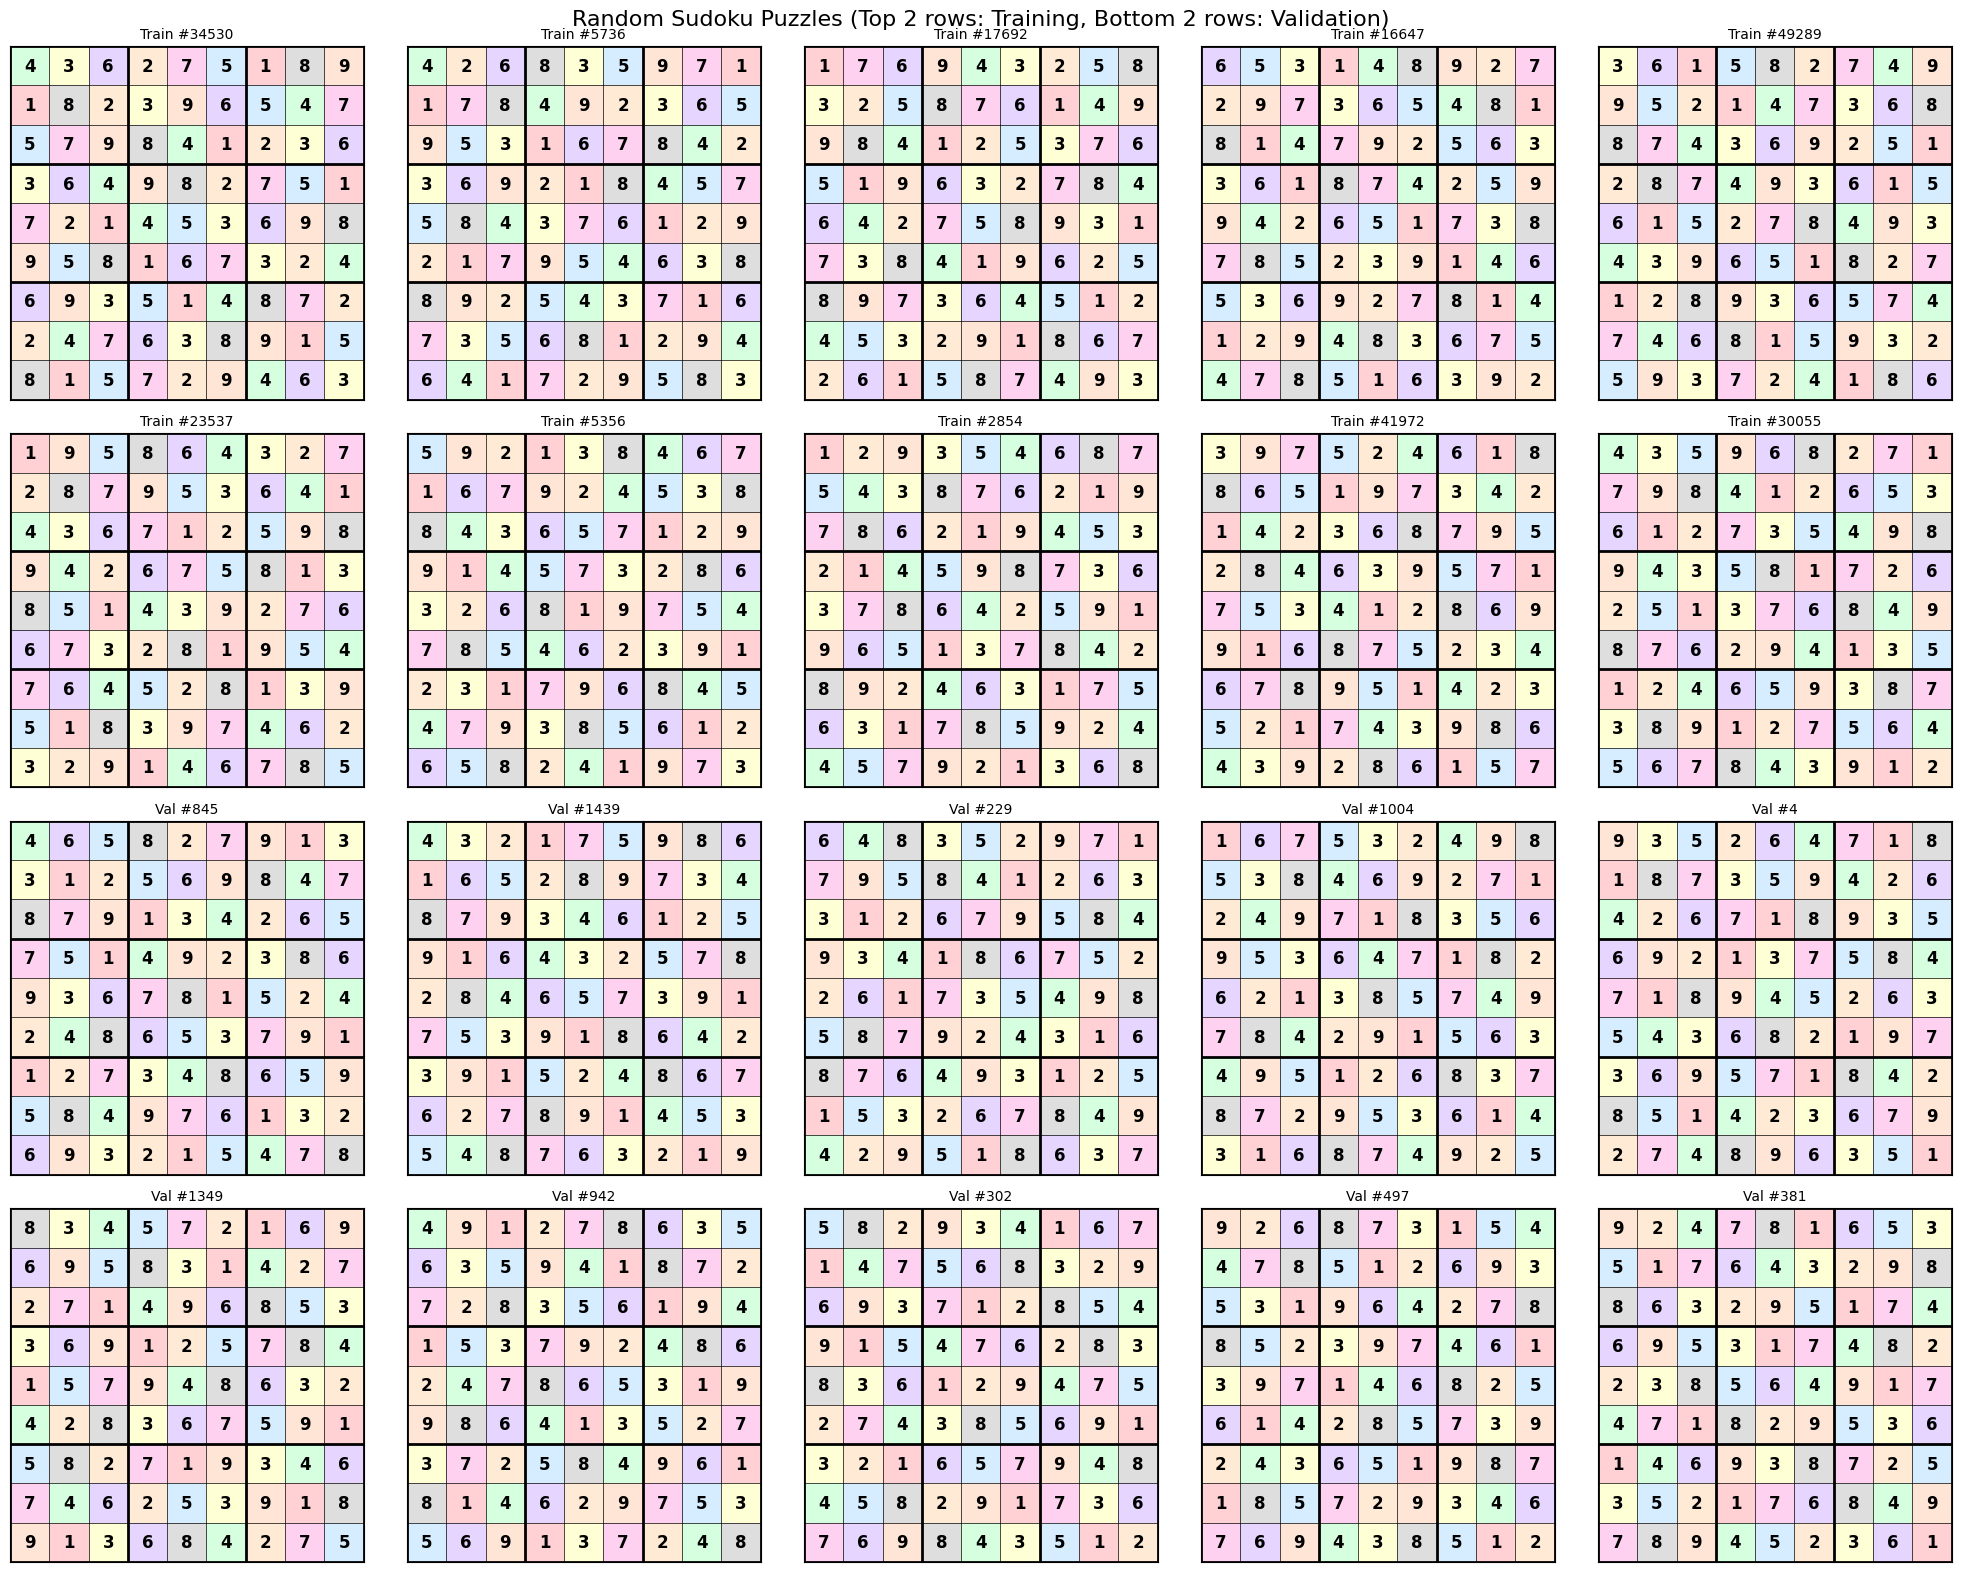

In [6]:
generator = SudokuGenerator(backend='torch', bit_width='4bit', device=device)
target, position, puzzles, original_puzzle = generator.generate_target_context_pairs(size=TRAIN_PUZZLES, k=SAMPLES_PER_PUZZLE, shuffle=True)
val_target, val_position, val_puzzles, val_original_puzzle = generator.generate_target_context_pairs(size=VAL_PUZZLES, k=SAMPLES_PER_PUZZLE, shuffle=True)

print(f"Training data shapes:")
print(f"  target: {target.shape}, dtype: {target.dtype}")
print(f"  position: {position.shape}, dtype: {position.dtype}")
print(f"  puzzles: {puzzles.shape}, dtype: {puzzles.dtype}")
print(f"  original_puzzle: {original_puzzle.shape}, dtype: {original_puzzle.dtype}")
print(f"\nValidation data shapes:")
print(f"  val_target: {val_target.shape}, dtype: {val_target.dtype}")
print(f"  val_position: {val_position.shape}, dtype: {val_position.dtype}")
print(f"  val_puzzles: {val_puzzles.shape}, dtype: {val_puzzles.dtype}")
print(f"  val_original_puzzle: {val_original_puzzle.shape}, dtype: {val_original_puzzle.dtype}")

# Visualize some random sudoku puzzles from training and validation sets
def visualize_sudoku(puzzle, title="Sudoku Puzzle"):
    """Visualize a single sudoku puzzle"""
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # Convert to numpy if tensor
    if torch.is_tensor(puzzle):
        puzzle = puzzle.cpu().numpy()
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=16, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    
    return fig, ax

# Define colors for each number (1-9)
number_colors = {
    1: '#FFB3BA',  # Light red
    2: '#FFDFBA',  # Light orange
    3: '#FFFFBA',  # Light yellow
    4: '#BAFFC9',  # Light green
    5: '#BAE1FF',  # Light blue
    6: '#D4BAFF',  # Light purple
    7: '#FFB3E6',  # Light pink
    8: '#C9C9C9',  # Light gray
    9: '#FFD4BA',  # Light peach
}

# Select 10 random indices from training set
train_indices = np.random.choice(len(puzzles), size=min(10, len(puzzles)), replace=False)

# Select 10 random indices from validation set
val_indices = np.random.choice(len(val_puzzles), size=min(10, len(val_puzzles)), replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('Random Sudoku Puzzles (Top 2 rows: Training, Bottom 2 rows: Validation)', fontsize=16)

# Plot training puzzles
for idx, train_idx in enumerate(train_indices):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    puzzle = puzzles[train_idx].cpu().numpy() if torch.is_tensor(puzzles[train_idx]) else puzzles[train_idx]
    
    # Fill cells with colors based on numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                color = number_colors[puzzle[i, j]]
                rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                         edgecolor='none', facecolor=color, alpha=0.6)
                ax.add_patch(rect)
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Train #{train_idx}', fontsize=10)

# Plot validation puzzles
for idx, val_idx in enumerate(val_indices):
    row = (idx // 5) + 2  # Start from row 2
    col = idx % 5
    ax = axes[row, col]
    
    puzzle = val_puzzles[val_idx].cpu().numpy() if torch.is_tensor(val_puzzles[val_idx]) else val_puzzles[val_idx]
    
    # Fill cells with colors based on numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                color = number_colors[puzzle[i, j]]
                rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                         edgecolor='none', facecolor=color, alpha=0.6)
                ax.add_patch(rect)
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Val #{val_idx}', fontsize=10)

plt.tight_layout()
plt.show()



Starting training from scratch
	Epoch 1/100, Average Loss: 0.577699 Positive Loss:0.577699 Negative Loss:0.000000 Train Accuracy: 0.109717 (10.97%) Time: 1.88s
	Epoch 2/100, Average Loss: 0.480054 Positive Loss:0.480054 Negative Loss:0.000000 Train Accuracy: 0.112050 (11.21%) Time: 1.54s
	Epoch 3/100, Average Loss: 0.456681 Positive Loss:0.456681 Negative Loss:0.000000 Train Accuracy: 0.112050 (11.21%) Time: 1.47s
	Epoch 4/100, Average Loss: 0.432948 Positive Loss:0.432948 Negative Loss:0.000000 Train Accuracy: 0.112050 (11.21%) Time: 1.55s
	Epoch 5/100, Average Loss: 0.373051 Positive Loss:0.373051 Negative Loss:0.000000 Train Accuracy: 0.195450 (19.55%) Time: 1.49s
	Epoch 6/100, Average Loss: 0.256502 Positive Loss:0.256502 Negative Loss:0.000000 Train Accuracy: 0.535717 (53.57%) Time: 1.58s
	Epoch 7/100, Average Loss: 0.197095 Positive Loss:0.197095 Negative Loss:0.000000 Train Accuracy: 0.774683 (77.47%) Time: 1.52s
	Epoch 8/100, Average Loss: 0.159944 Positive Loss:0.159944 Negati

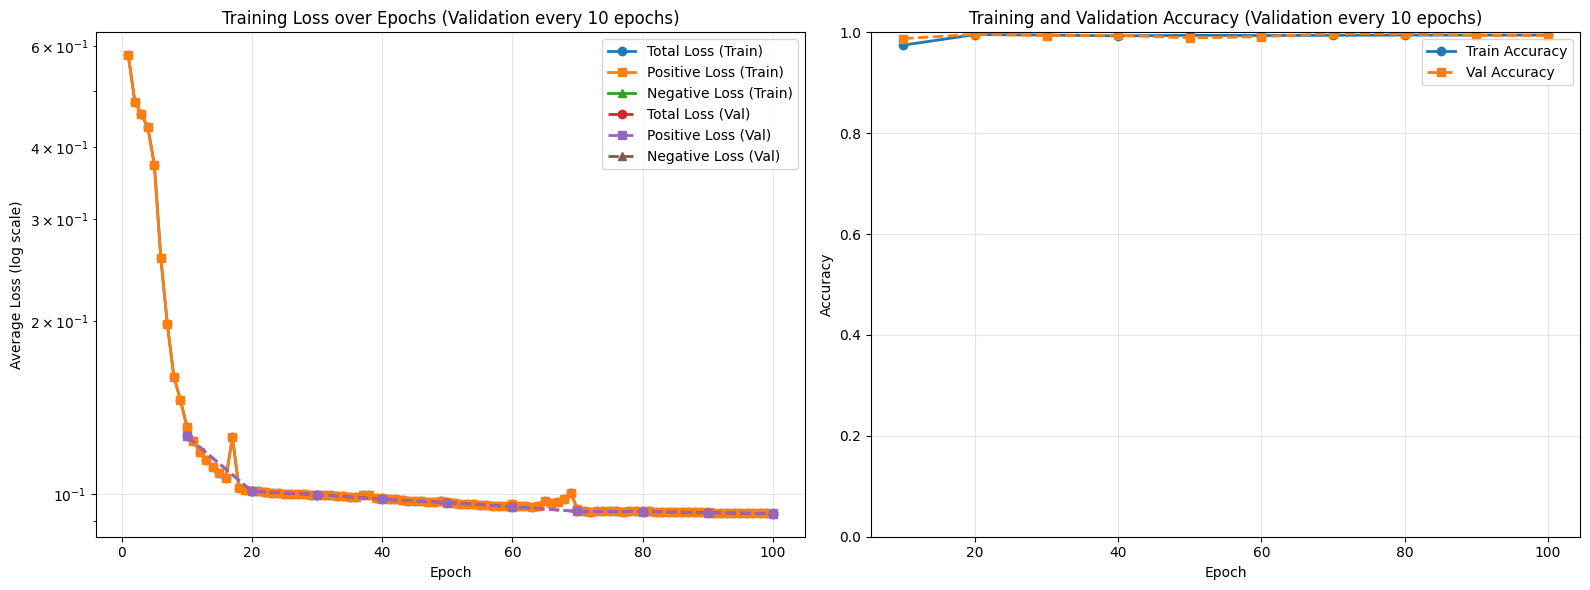

In [7]:
epoch_losses = []
epoch_positive_losses = []
epoch_negative_losses = []
val_epoch_losses = []
val_epoch_positive_losses = []
val_epoch_negative_losses = []
validation_epochs = []  # Track which epochs we validated on
train_accuracies = []  # Track training accuracies
val_accuracies = []  # Track validation accuracies

# Checkpoint loading
start_epoch = 0
if LOAD_CHECKPOINT and os.path.exists(LOAD_CHECKPOINT):
    print(f"Loading checkpoint from {LOAD_CHECKPOINT}")
    checkpoint = torch.load(LOAD_CHECKPOINT, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    epoch_losses = checkpoint.get('epoch_losses', [])
    epoch_positive_losses = checkpoint.get('epoch_positive_losses', [])
    epoch_negative_losses = checkpoint.get('epoch_negative_losses', [])
    val_epoch_losses = checkpoint.get('val_epoch_losses', [])
    val_epoch_positive_losses = checkpoint.get('val_epoch_positive_losses', [])
    val_epoch_negative_losses = checkpoint.get('val_epoch_negative_losses', [])
    validation_epochs = checkpoint.get('validation_epochs', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    if USE_AMP and scaler is not None:
        scaler.load_state_dict(checkpoint.get('scaler_state_dict', {}))
    
    # Load hyperparameters from checkpoint
    loaded_hp = checkpoint.get('hyperparameters', {})
    print(f"Resuming from epoch {start_epoch}")
    print(f"Loaded hyperparameters: {loaded_hp}")
else:
    print("Starting training from scratch")

for epoch in range(start_epoch, N_EPOCHS):
    epoch_start_time = time.time()
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    epoch_positive_loss = 0.0
    epoch_negative_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = 0
    
    # Loop over batches
    for i in range(0, len(target), BATCH_SIZE):
        # Get batch and ensure it's on the correct device
        batch_target = target[i:i+BATCH_SIZE].long().to(device)
        batch_position = position[i:i+BATCH_SIZE].long().to(device)
        batch_puzzles = puzzles[i:i+BATCH_SIZE].long().to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Mixed precision training with autocast
        if USE_AMP:
            with torch.autocast(device_type=device.type, dtype=amp_dtype):
                # Compute loss
                loss, negative_loss, positive_loss, accuracy = model.loss(batch_target, batch_position, batch_puzzles)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            # Update weights with gradient unscaling
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training without mixed precision
            loss, negative_loss, positive_loss, accuracy = model.loss(batch_target, batch_position, batch_puzzles)
            loss.backward()
            optimizer.step()
        
        # Track loss and accuracy
        batch_size = batch_puzzles.shape[0]
        epoch_loss += loss.item()
        epoch_positive_loss += positive_loss.item()
        epoch_negative_loss += negative_loss.item()
        epoch_correct += (accuracy * batch_size).item()
        epoch_total += batch_size
        num_batches += 1
    
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch statistics
    avg_loss = epoch_loss / num_batches
    avg_positive_loss = epoch_positive_loss / num_batches
    avg_negative_loss = epoch_negative_loss / num_batches
    train_accuracy = epoch_correct / epoch_total
    epoch_losses.append(avg_loss)
    epoch_positive_losses.append(avg_positive_loss)
    epoch_negative_losses.append(avg_negative_loss)
    print(f"\tEpoch {epoch+1}/{N_EPOCHS}, Average Loss: {avg_loss:.6f} Positive Loss:{avg_positive_loss:.6f} Negative Loss:{avg_negative_loss:.6f} Train Accuracy: {train_accuracy:.6f} ({train_accuracy*100:.2f}%) Time: {epoch_time:.2f}s")
    
    # Evaluate on validation set every VALIDATE_PERIOD epochs
    if (epoch + 1) % VALIDATE_PERIOD == 0 or (epoch + 1) == N_EPOCHS:
        val_start_time = time.time()
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_positive_loss = 0.0
        val_negative_loss = 0.0
        val_num_batches = 0
        
        # Store training accuracy for this validation epoch
        train_accuracies.append(train_accuracy)
        
        # Calculate validation accuracy and loss
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            # Also use autocast for validation for consistency
            with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=USE_AMP):
                for i in range(0, len(val_target), BATCH_SIZE):
                    # Get validation batch and ensure it's on the correct device
                    val_batch_target = val_target[i:i+BATCH_SIZE].long().to(device)
                    val_batch_position = val_position[i:i+BATCH_SIZE].long().to(device)
                    val_batch_puzzles = val_puzzles[i:i+BATCH_SIZE].long().to(device)
                    
                    # Compute validation loss and accuracy
                    loss, negative_loss, positive_loss, accuracy = model.loss(val_batch_target, val_batch_position, val_batch_puzzles)
                    
                    # Track validation loss
                    val_loss += loss.item()
                    val_positive_loss += positive_loss.item()
                    val_negative_loss += negative_loss.item()
                    val_num_batches += 1
                    
                    # Track accuracy
                    batch_size = val_batch_puzzles.shape[0]
                    val_correct += (accuracy * batch_size).item()
                    val_total += batch_size
        
        val_time = time.time() - val_start_time
        
        # Print validation statistics
        avg_val_loss = val_loss / val_num_batches
        avg_val_positive_loss = val_positive_loss / val_num_batches
        avg_val_negative_loss = val_negative_loss / val_num_batches
        val_accuracy = val_correct / val_total
        val_epoch_losses.append(avg_val_loss)
        val_epoch_positive_losses.append(avg_val_positive_loss)
        val_epoch_negative_losses.append(avg_val_negative_loss)
        val_accuracies.append(val_accuracy)
        validation_epochs.append(epoch + 1)
        print(f"\t✓ Validation Loss: {avg_val_loss:.6f} Positive Loss:{avg_val_positive_loss:.6f} Negative Loss:{avg_val_negative_loss:.6f}")
        print(f"\t✓ Val Accuracy: {val_accuracy:.6f} ({val_accuracy*100:.2f}%) Inference Time: {val_time:.2f}s")
    
    # Save checkpoint every CHECKPOINT_PERIOD epochs
    if SAVE_CHECKPOINT and (epoch + 1) % CHECKPOINT_PERIOD == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch_losses': epoch_losses,
            'epoch_positive_losses': epoch_positive_losses,
            'epoch_negative_losses': epoch_negative_losses,
            'val_epoch_losses': val_epoch_losses,
            'val_epoch_positive_losses': val_epoch_positive_losses,
            'val_epoch_negative_losses': val_epoch_negative_losses,
            'validation_epochs': validation_epochs,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'hyperparameters': {
                'N_EPOCHS': N_EPOCHS,
                'LEARNING_RATE': LEARNING_RATE,
                'ATTENTION_DIM': ATTENTION_DIM,
                'N_HEADS': N_HEADS,
                'EMBEDDING_DIM': EMBEDDING_DIM,
                'TRAIN_PUZZLES': TRAIN_PUZZLES,
                'VAL_PUZZLES': VAL_PUZZLES,
                'BATCH_SIZE': BATCH_SIZE,
                'SAMPLES_PER_PUZZLE': SAMPLES_PER_PUZZLE,
                'NEGATIVE_SAMPLES_SIZE': NEGATIVE_SAMPLES_SIZE,
                'USE_NEGATIVE_SAMPLES': USE_NEGATIVE_SAMPLES,
            }
        }
        if USE_AMP and scaler is not None:
            checkpoint['scaler_state_dict'] = scaler.state_dict()
        
        checkpoint_path = get_checkpoint_filename(epoch + 1)
        torch.save(checkpoint, checkpoint_path)
        print(f"\t💾 Checkpoint saved at {checkpoint_path}")

# Save final checkpoint
if SAVE_CHECKPOINT:
    checkpoint = {
        'epoch': N_EPOCHS - 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch_losses': epoch_losses,
        'epoch_positive_losses': epoch_positive_losses,
        'epoch_negative_losses': epoch_negative_losses,
        'val_epoch_losses': val_epoch_losses,
        'val_epoch_positive_losses': val_epoch_positive_losses,
        'val_epoch_negative_losses': val_epoch_negative_losses,
        'validation_epochs': validation_epochs,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'hyperparameters': {
            'N_EPOCHS': N_EPOCHS,
            'LEARNING_RATE': LEARNING_RATE,
            'ATTENTION_DIM': ATTENTION_DIM,
            'N_HEADS': N_HEADS,
            'EMBEDDING_DIM': EMBEDDING_DIM,
            'TRAIN_PUZZLES': TRAIN_PUZZLES,
            'VAL_PUZZLES': VAL_PUZZLES,
            'BATCH_SIZE': BATCH_SIZE,
            'SAMPLES_PER_PUZZLE': SAMPLES_PER_PUZZLE,
            'NEGATIVE_SAMPLES_SIZE': NEGATIVE_SAMPLES_SIZE,
            'USE_NEGATIVE_SAMPLES': USE_NEGATIVE_SAMPLES,
        }
    }
    if USE_AMP and scaler is not None:
        checkpoint['scaler_state_dict'] = scaler.state_dict()
    
    checkpoint_path = get_checkpoint_filename()
    torch.save(checkpoint, checkpoint_path)
    print(f"💾 Final checkpoint saved at {checkpoint_path}")
    
    # Also save the model in a portable format for easy loading
    model_path = os.path.join(CHECKPOINT_DIR, f"sudoku2vec_final_emb{EMBEDDING_DIM}.pt")
    model.save_model(model_path)
    print(f"💾 Portable model saved at {model_path}")

# Plot the loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss plot
ax1.plot(range(1, N_EPOCHS + 1), epoch_losses, marker='o', linestyle='-', linewidth=2, label='Total Loss (Train)')
ax1.plot(range(1, N_EPOCHS + 1), epoch_positive_losses, marker='s', linestyle='-', linewidth=2, label='Positive Loss (Train)')
ax1.plot(range(1, N_EPOCHS + 1), epoch_negative_losses, marker='^', linestyle='-', linewidth=2, label='Negative Loss (Train)')

# Plot validation at the epochs where it was actually run
ax1.plot(validation_epochs, val_epoch_losses, marker='o', linestyle='--', linewidth=2, label='Total Loss (Val)')
ax1.plot(validation_epochs, val_epoch_positive_losses, marker='s', linestyle='--', linewidth=2, label='Positive Loss (Val)')
ax1.plot(validation_epochs, val_epoch_negative_losses, marker='^', linestyle='--', linewidth=2, label='Negative Loss (Val)')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss (log scale)')
ax1.set_title(f'Training Loss over Epochs (Validation every {VALIDATE_PERIOD} epochs)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(validation_epochs, train_accuracies, marker='o', linestyle='-', linewidth=2, label='Train Accuracy')
ax2.plot(validation_epochs, val_accuracies, marker='s', linestyle='--', linewidth=2, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title(f'Training and Validation Accuracy (Validation every {VALIDATE_PERIOD} epochs)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

Generating 100 sudoku grids for t-SNE visualization...


/workspace/svi.on.mnist/sudoku.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([torch.tensor(p, dtype=torch.int8 if self.bit_width == '4bit' else torch.int32, device=self.device) for p in puzzles])


Generated 100 puzzles
Target tokens shape: torch.Size([100])
Positions shape: torch.Size([100, 2])
Puzzles shape: torch.Size([100, 9, 9])

Extracted embeddings at masked positions: (100, 15)
Embedding dimension: 15

Applying t-SNE (this may take a moment)...
t-SNE completed. Reduced to shape: (100, 2)


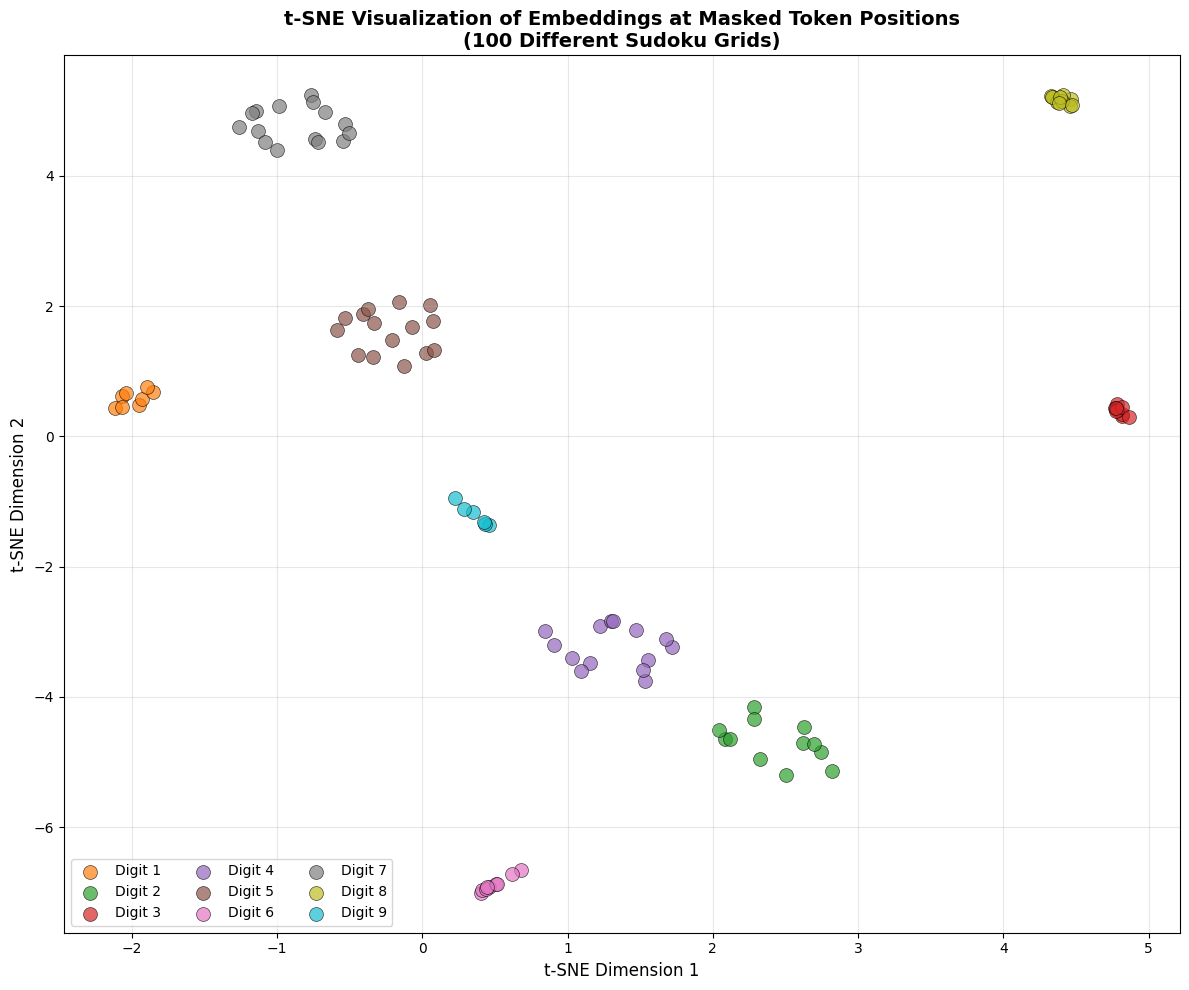


Statistics:
Total samples: 100
Digit distribution:
  Digit 1: 8 samples (8.0%)
  Digit 2: 12 samples (12.0%)
  Digit 3: 10 samples (10.0%)
  Digit 4: 14 samples (14.0%)
  Digit 5: 15 samples (15.0%)
  Digit 6: 9 samples (9.0%)
  Digit 7: 15 samples (15.0%)
  Digit 8: 11 samples (11.0%)
  Digit 9: 6 samples (6.0%)

Embedding statistics:
  Mean: 0.0002
  Std: 0.0159
  Min: -0.0688
  Max: 0.0486


In [8]:
# t-SNE Visualization of Embeddings at Masked Positions

from sklearn.manifold import TSNE

print("Generating 100 sudoku grids for t-SNE visualization...")

# Generate 100 different sudoku grids with 1 sample per puzzle (100 masked positions total)
tsne_target, tsne_position, tsne_puzzles, tsne_original = generator.generate_target_context_pairs(
    size=100, k=1, shuffle=True
)

print(f"Generated {len(tsne_target)} puzzles")
print(f"Target tokens shape: {tsne_target.shape}")
print(f"Positions shape: {tsne_position.shape}")
print(f"Puzzles shape: {tsne_puzzles.shape}")

# Set model to evaluation mode
model.eval()

# Get embeddings at masked positions
all_embeddings = []
all_targets = []
all_positions = []

with torch.no_grad():
    # Use autocast for consistency
    with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=USE_AMP):
        # Process all samples at once (they're only 100)
        batch_target = tsne_target.long().to(device)
        batch_position = tsne_position.long().to(device)
        batch_puzzles = tsne_puzzles.long().to(device)
        
        # Forward pass
        output, attention, target_token_with_position, grid_embeddings_flat = model.forward(
            batch_target, batch_position, batch_puzzles, mask=True
        )
        
        # Extract only the embedding portion (without position vectors) from output
        # output is [batch, 81, total_dim] where total_dim = embedding_dim + 2
        output_embeddings = output[:, :, :model.embedding_dim]  # shape [batch, 81, embedding_dim]
        
        # Extract embeddings at masked positions
        batch_indices = torch.arange(len(batch_target), device=device)
        linear_indices = batch_position[:, 1] * 9 + batch_position[:, 0]  # [batch]
        
        # Get output embeddings at target positions
        embeddings_at_masked = output_embeddings[batch_indices, linear_indices, :]  # [batch, embedding_dim]
        
        # Convert to numpy for t-SNE
        embeddings_np = embeddings_at_masked.cpu().float().numpy()
        targets_np = batch_target.cpu().numpy()
        positions_np = batch_position.cpu().numpy()

print(f"\nExtracted embeddings at masked positions: {embeddings_np.shape}")
print(f"Embedding dimension: {embeddings_np.shape[1]}")

# Apply t-SNE to reduce to 2D
print("\nApplying t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_np)

print(f"t-SNE completed. Reduced to shape: {embeddings_2d.shape}")

# Visualize the t-SNE embeddings
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Color by target digit (1-9)
# Create a colormap for digits 1-9
colors = plt.cm.tab10(np.linspace(0, 1, 10))
digit_colors = {i: colors[i] for i in range(10)}

# Plot each point colored by its target digit
for digit in range(1, 10):  # Digits 1-9
    mask = targets_np == digit
    if mask.any():
        ax.scatter(
            embeddings_2d[mask, 0], 
            embeddings_2d[mask, 1], 
            c=[digit_colors[digit]], 
            label=f'Digit {digit}',
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5
        )

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('t-SNE Visualization of Embeddings at Masked Token Positions\n(100 Different Sudoku Grids)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, ncol=3)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print("\nStatistics:")
print(f"Total samples: {len(embeddings_2d)}")
print(f"Digit distribution:")
for digit in range(1, 10):
    count = (targets_np == digit).sum()
    print(f"  Digit {digit}: {count} samples ({count/len(targets_np)*100:.1f}%)")

print("\nEmbedding statistics:")
print(f"  Mean: {embeddings_np.mean():.4f}")
print(f"  Std: {embeddings_np.std():.4f}")
print(f"  Min: {embeddings_np.min():.4f}")
print(f"  Max: {embeddings_np.max():.4f}")


Model saved to ./sudoku2vec_trained_model.pt

EMBEDDING EXTRACTION DEMONSTRATION

1. All Token Embeddings:
   Shape: torch.Size([10, 15])
   Description: [vocab_size=10, embedding_dim=15]

2. Embedding for Token 5:
   Shape: torch.Size([1, 15])
   Values: tensor([-1.4141,  0.5000, -1.2656,  0.9922,  0.4648,  1.2031,  1.3672,  0.8711,
        -1.4297,  0.9414, -1.0703, -0.2480, -0.5000,  0.2598, -0.1582],
       device='cuda:0', dtype=torch.bfloat16)

3. Embeddings for Tokens [1, 3, 5, 7, 9]:
   Shape: torch.Size([5, 15])
   Description: [num_tokens=5, embedding_dim=15]


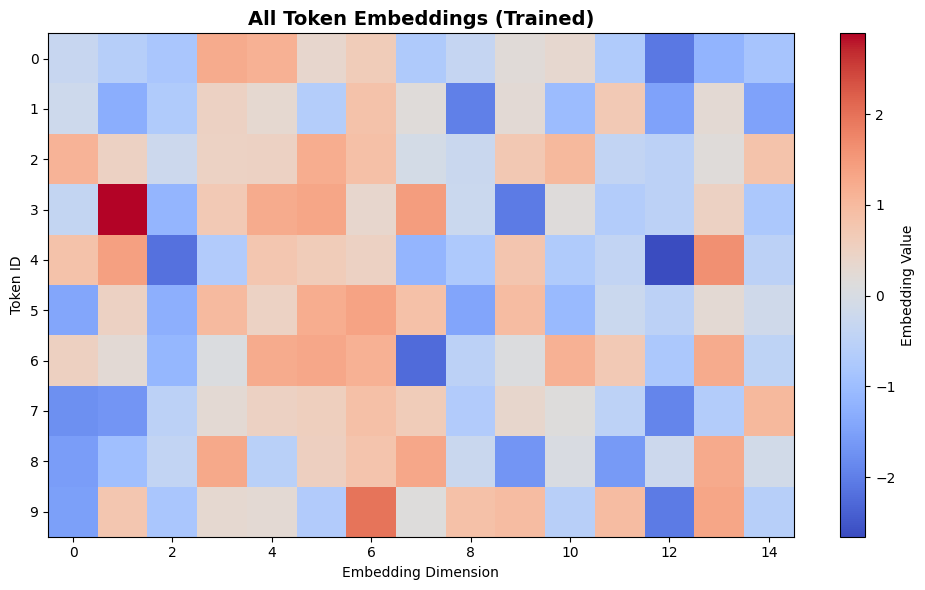


MODEL LOADING DEMONSTRATION

Loading model from ./sudoku2vec_trained_model.pt...
Model loaded from ./sudoku2vec_trained_model.pt
Configuration: vocab_size=10, embedding_dim=15, attention_dim=9, num_heads=9

Verifying loaded model...
✓ Outputs match: False
  Maximum difference: 0.003806

USAGE EXAMPLE: Load model in a different program

To load this model in another Python program, simply use:

```python
import torch
from your_module import Sudoku2Vec  # Import the class definition

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Sudoku2Vec.load_model('sudoku2vec_trained_model.pt', device=device)

# Get embeddings
embeddings = model.get_embeddings()  # Get all embeddings
token_embedding = model.get_embedding_for_token(5)  # Get embedding for token 5

# Use the model for inference
output, attention, target_with_pos, grid_emb = model.forward(target, position, puzzle)
```

Note: Make sure the Sudoku2Vec class definition is available in your program

In [9]:
# Save the trained model using the new save_model method
model_save_path = "./sudoku2vec_trained_model.pt"
model.save_model(model_save_path)

# Demonstrate getting embeddings
print("\n" + "="*80)
print("EMBEDDING EXTRACTION DEMONSTRATION")
print("="*80)

# Get all embeddings
all_embeddings = model.get_embeddings()
print(f"\n1. All Token Embeddings:")
print(f"   Shape: {all_embeddings.shape}")
print(f"   Description: [vocab_size={all_embeddings.shape[0]}, embedding_dim={all_embeddings.shape[1]}]")

# Get embedding for a specific token (e.g., token 5)
token_5_embedding = model.get_embedding_for_token(5)
print(f"\n2. Embedding for Token 5:")
print(f"   Shape: {token_5_embedding.shape}")
print(f"   Values: {token_5_embedding.squeeze()}")

# Get embeddings for multiple tokens
multiple_tokens = [1, 3, 5, 7, 9]
multiple_embeddings = model.get_embedding_for_token(multiple_tokens)
print(f"\n3. Embeddings for Tokens {multiple_tokens}:")
print(f"   Shape: {multiple_embeddings.shape}")
print(f"   Description: [num_tokens={len(multiple_tokens)}, embedding_dim={multiple_embeddings.shape[-1]}]")

# Visualize all embeddings as a heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
embeddings_np = all_embeddings.cpu().float().numpy()
im = ax.imshow(embeddings_np, cmap='coolwarm', aspect='auto', interpolation='nearest')
ax.set_title('All Token Embeddings (Trained)', fontweight='bold', fontsize=14)
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Token ID')
ax.set_yticks(range(all_embeddings.shape[0]))
plt.colorbar(im, ax=ax, label='Embedding Value')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("MODEL LOADING DEMONSTRATION")
print("="*80)

# Demonstrate loading the model in a fresh instance
print(f"\nLoading model from {model_save_path}...")
loaded_model = Sudoku2Vec.load_model(model_save_path, device=device)

# Verify the loaded model works correctly
print("\nVerifying loaded model...")
test_target = target[0:1]
test_position = position[0:1]
test_puzzle = puzzles[0:1]

with torch.no_grad():
    original_output, _, _, _ = model.forward(test_target.long().to(device), 
                                             test_position.long().to(device), 
                                             test_puzzle.long().to(device))
    loaded_output, _, _, _ = loaded_model.forward(test_target.long().to(device), 
                                                   test_position.long().to(device), 
                                                   test_puzzle.long().to(device))
    
    # Check if outputs match
    outputs_match = torch.allclose(original_output.float(), loaded_output.float(), atol=1e-5)
    print(f"✓ Outputs match: {outputs_match}")
    
    if not outputs_match:
        max_diff = (original_output.float() - loaded_output.float()).abs().max()
        print(f"  Maximum difference: {max_diff:.6f}")
    
print("\n" + "="*80)
print("USAGE EXAMPLE: Load model in a different program")
print("="*80)
print("""
To load this model in another Python program, simply use:

```python
import torch
from your_module import Sudoku2Vec  # Import the class definition

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Sudoku2Vec.load_model('sudoku2vec_trained_model.pt', device=device)

# Get embeddings
embeddings = model.get_embeddings()  # Get all embeddings
token_embedding = model.get_embedding_for_token(5)  # Get embedding for token 5

# Use the model for inference
output, attention, target_with_pos, grid_emb = model.forward(target, position, puzzle)
```

Note: Make sure the Sudoku2Vec class definition is available in your program!
""")
